# Анализ поведения пользователей мобильного приложения

<b>Цель исследования: </b><br>
1) разобраться, как ведут себя пользователи мобильного приложения стартапа, который продаёт продукты питания.<br> 
2) изучить воронку продаж, узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах и на каких именно?<br>
3) исследовать результаты A/A/B-эксперимента. 

<b>A/A/B-эксперимент: </b><br>
дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо выяснить, какой шрифт лучше.

<b>Ход исследования: </b>
1) Обзор данных.<br>
2) Предобработка данных:<br>
3) Исследовательский анализ:<br>
- Сколько всего событий в логе?<br>
- Сколько всего пользователей в логе?<br>
- Сколько в среднем событий приходится на пользователя?<br>
- За какой период данные? Определить максимальную и минимальную дату. Построить гистограмму по дате и времени. Проверить одинаково ли полные данные за весь период? <i>(Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные»)</i>. Определить, с какого момента данные полные и отбросить более старые. Данные за какой период времени предоставлены?<br>
- Много ли событий и пользователей были потеряны в результате очистки от "старых" данных?<br>
- Проверить, что есть пользователи из всех трёх экспериментальных групп.<br>

4) Анализ воронки событий:<br>
- Просмотреть, какие события есть в логах, как часто они встречаются. Отсортировать события по частоте.<br>
- Посчитать, сколько пользователей совершали каждое из этих событий. Отсортировать события по числу пользователей. Посчитать долю пользователей, которые хоть раз совершали событие.<br>
- Сделать предположение, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? .<br>
- Посчитать по воронке событий, какая доля пользователей проходит на следующий шаг воронки <i>(от числа пользователей на предыдущем). (То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B)</i>.<br>
- На каком шаге теряется больше всего пользователей?<br>
- Какая доля пользователей доходит от первого события до оплаты?

5) Анализ результатов эксперимента:<br>
- Сколько пользователей в каждой экспериментальной группе?<br>
- Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверить, находят ли статистические критерии разницу между выборками 246 и 247.<br>
- Выбрать самое популярное событие. Посчитать число пользователей, совершивших это событие в каждой из контрольных групп. Посчитать долю пользователей, совершивших это событие. Проверить, будет ли отличие между группами статистически достоверным. Проделать то же самое для всех других событий. Можно ли сказать, что разбиение на группы работает корректно?<br>
- Аналогично сделать с группой с изменённым шрифтом. Сравнить результаты с каждой из контрольных групп в отдельности по каждому событию. Сравнить результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?<br>
- Определить уровень значимости при проверке статистических гипотез выше? Посчитать, сколько проверок статистических гипотез было сделано. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить?<br>

6) Подготовка общего вывода.

<b>Описание данных:</b>

<b>EventName</b> — название события;<br>
<b>DeviceIDHash</b> — уникальный идентификатор пользователя;<br>
<b>EventTimestamp</b> — время события;<br>
<b>ExpId</b> — номер эксперимента: 
- 246 и 247 — контрольные группы;
- 248 — экспериментальная.

### 1. Обзор данных

In [1]:
#Подключим необходимые библиотеки
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as mth 
from plotly import graph_objects as go
import warnings

In [2]:
#задаем исходные настройки
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [3]:
#Загрузим данные
logo = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [4]:
#Базовая функция для ознакомления с данными: инфо о типах, пропусках, явных дубликатах
def show_data(df):
    display(df.head(20))
    print('-----')
    print('Информация о типах данных')
    df.info()
    print('-----')
    for col in df.columns:
        print('Название:', col, '\nПропусков:\t', df[col].isna().sum(), 'Процент пропусков:\t', round(df[col].isna().sum() *100 / len(df[col])))
    round(df[col].isna().sum() *100 / len(df[col]))
    print('-----')
    print('Явных дубликатов')
    print(df.duplicated().sum())

In [5]:
show_data(logo)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


-----
Информация о типах данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
-----
Название: EventName 
Пропусков:	 0 Процент пропусков:	 0
Название: DeviceIDHash 
Пропусков:	 0 Процент пропусков:	 0
Название: EventTimestamp 
Пропусков:	 0 Процент пропусков:	 0
Название: ExpId 
Пропусков:	 0 Процент пропусков:	 0
-----
Явных дубликатов
413


In [6]:
logo['ExpId'].value_counts()

248    85747
246    80304
247    78075
Name: ExpId, dtype: int64

В каждой группе почти равное количество пользователей.

<b>Краткий вывод: </b>В ходе предварительного просмотра данных пропусков не обнаружено, были обнаружены явные дубликаты (413), которые будут удалены на следующем этапе исследования. В каждой группе почти равное количество участников.

### 2. Предобработка данных

<u><b>Удаление явных дубликатов

In [7]:
logo = logo.drop_duplicates().reset_index(drop=True)
logo.duplicated().sum()

0

<u><b>Привидение наименования столбцов в "змеиный" формат

In [8]:
logo.rename(columns={'EventName':'event_name', 'DeviceIDHash':'device_id', 'EventTimestamp':'event_time_stamp', 'ExpId':'group_id'}, inplace=True)
logo.columns

Index(['event_name', 'device_id', 'event_time_stamp', 'group_id'], dtype='object')

<u><b> Преобразование типов данных

Выделим из столбца `event_time_stamp` дату и время, а также отдельно дату.

In [9]:
logo['date_time'] = pd.to_datetime(logo['event_time_stamp'], unit='s') 
logo['date'] = logo['date_time'].dt.date
logo.head()

,event_name,device_id,event_time_stamp,group_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


<div style="text-align: justify ">
<b>Вывод: </b> В ходе ознакомления и предобработки данных стало известно, что имеется массив данных <b>logs_exp</b>, который содержит данные о названии события, уникальном идентификаторе пользователя, времени события и номер группы эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная. Из столбца <b>event_time_stamp</b> были выделены дата и время, а также просто дата. Для "красоты" отображения наименования столбцов переведено в "змеиный" формат. В ходе предварительного просмотра данных пропусков не обнаружено, были обнаружены и удалены 413 явных дубликата. Каждая группа содержит почти равное количество участников.

### 3. Исследовательский анализ данных

<u><b> Количество событий в логе

In [10]:
print('Всего', logo['event_name'].count(), 'событий в логе')
print('Всего', len(logo['event_name'].unique()), 'уникальных событий в логе')
logo['event_name'].value_counts().reset_index()

Всего 243713 событий в логе
Всего 5 уникальных событий в логе


,index,event_name
0,MainScreenAppear,119101
1,OffersScreenAppear,46808
2,CartScreenAppear,42668
3,PaymentScreenSuccessful,34118
4,Tutorial,1018


<b>Краткий вывод: </b>Всего в логе 243 713 события пяти различных типов. Больше всего событий "главный экран" (119 101), меньше всего "обучения" (1018).

<u><b> Количество пользователей в логе

In [11]:
print('Всего', len(logo['device_id'].unique()), 'пользователей в логе')

Всего 7551 пользователей в логе


<u><b> Среднее количество событий на одного пользователя

In [12]:
print('В среднем на одного пользователя приходится', int(len(logo) / len(logo['device_id'].unique())), 'события.')

В среднем на одного пользователя приходится 32 события.


In [13]:
event_per_user = logo.groupby('device_id')['event_name'].count()
event_per_user.describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64

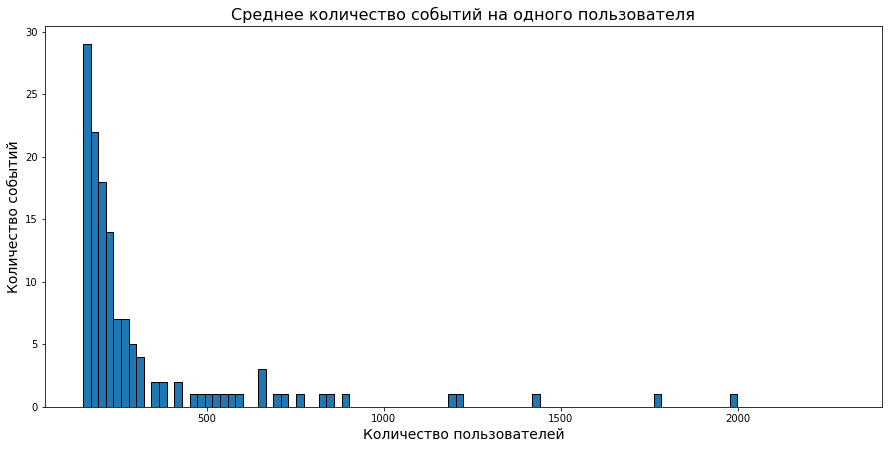

In [14]:
plt.figure(figsize=(15, 7))
plt.hist(event_per_user, bins=100, range=(150,2300), edgecolor='black') 
plt.xlabel('Количество пользователей', fontsize = 14)
plt.ylabel('Количество событий', fontsize = 14)
plt.title('Среднее количество событий на одного пользователя', fontsize = 16);

<b>Краткий вывод: </b> В среднем на одного пользователя приходится 32 события. Интересен факт, что максимальным числом действия на одного пользователя было 2 307 событий.

<u><b> Временной период анализа данных

In [15]:
print('Старт исследования: ', logo['date_time'].min())
print('Конец исследования: ', logo['date_time'].max())
print('Период исследования: ', logo['date_time'].max() - logo['date_time'].min())

Старт исследования:  2019-07-25 04:43:36
Конец исследования:  2019-08-07 21:15:17
Период исследования:  13 days 16:31:41


Для исследования предоставлены данные почти за 14 дней. Исследование стартовало 25 июня 2019г. и закончилось 7 августа 2019г.

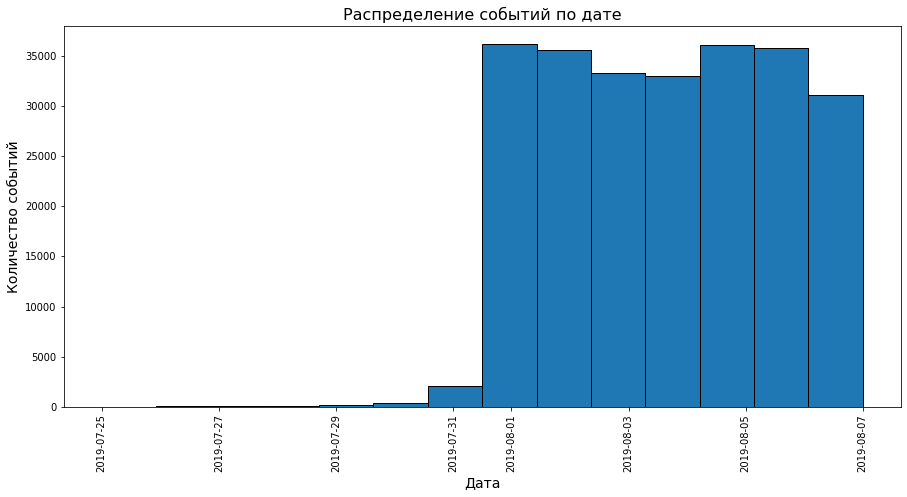

In [16]:
plt.figure(figsize =(15, 7))
logo['date'].hist(bins=14, edgecolor='black')                
plt.title('Распределение событий по дате', fontsize = 16)
plt.xticks(rotation=90)
plt.xlabel('Дата', fontsize = 14)
plt.ylabel('Количество событий', fontsize = 14)
plt.grid();

Как видно из гистограммы, с 1 августа 2019г. наблюдается резкий всплеск событий, который сохраняется до конца исследования. Возможно это связано с донастройкой параметров теста. Отсечем неполные данные из нашего анализа.

In [17]:
start_date = pd.to_datetime('2019-08-01', format = '%Y-%m-%d')
logo_filt = logo[logo['date_time'] >= start_date]
logo_filt

,event_name,device_id,event_time_stamp,group_id,date_time,date
2826,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2827,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2828,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2829,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2830,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
...,...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
243709,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
243710,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
243711,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


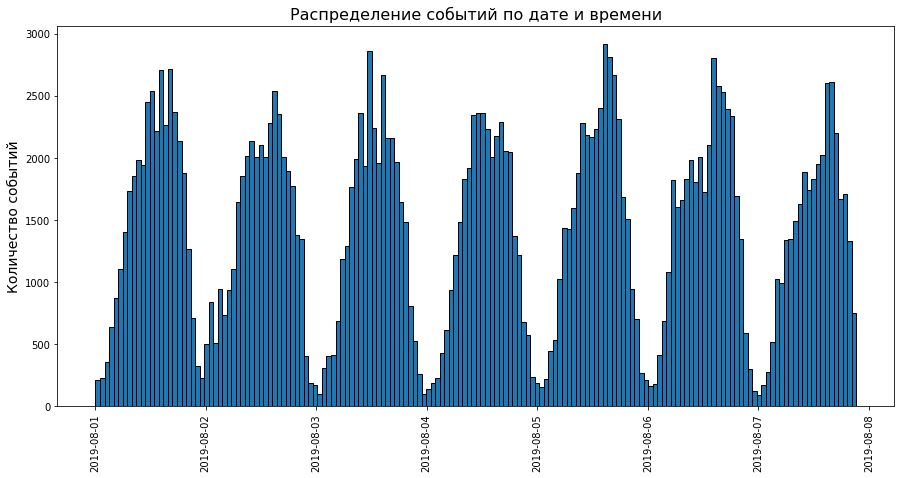

In [18]:
# распределение событий по дате и времени
plt.figure(figsize =(15, 7))
logo_filt['date_time'].hist(bins=168, edgecolor='black')
plt.title('Распределение событий по дате и времени', fontsize = 16)
plt.ylabel("Дата", fontsize = 14)
plt.ylabel("Количество событий", fontsize = 14)
plt.xticks(rotation=90)
plt.grid();

<b>Краткий вывод: </b> Для анализа были предоставлены данные за 14 дней за период с 25 июля по 7 августа 2019 года. Однако наблюдается сильный рост событий с 1 августа. Для продолжения исследования возьмем период с 1 по 7 августа на 7 дней.

<u><b> Оценка процента "потерянных" данных после "очистки"

In [19]:
# оцнка количества "потерянных" пользователей

print('Количество "потерянных" пользователей:',logo['device_id'].nunique()-logo_filt['device_id'].nunique())
print('Процент "потерянных" пользователей:', round(100-logo_filt['device_id'].nunique()/logo['device_id'].nunique()*100, 2), '%')

Количество "потерянных" пользователей: 17
Процент "потерянных" пользователей: 0.23 %


In [20]:
# оцнка количества "потерянных" событий

print('Количество "потерянных" событий:',len(logo)-len(logo_filt))
print('Процент "потерянных" событий:', round(100-len(logo_filt)/len(logo)*100, 2), '%')

Количество "потерянных" событий: 2826
Процент "потерянных" событий: 1.16 %


<b>Краткий вывод: </b> Всего из анализа было удалено 17 пользователей и 2 826 события. Процент "потерянных" данных чуть более 1%, что не скажется на резултьтах анализа. 

<u><b> Проверка пользователей по группам.

In [21]:
logo_filt['group_id'].value_counts().reset_index()

,index,group_id
0,248,84563
1,246,79302
2,247,77022


<b>Краткий вывод: </b> После фильтрации данных, в каждой группе соотношение событий по группам сохранилось примерно тем же. 

<div style="text-align: justify ">
<b>Вывод: </b> Всего в логе пройдено 243 713 событий пяти разных типов. Больше всего событий "главный экран" (119 101), меньше всего "обучения" (1018). Всего в логе 7 551 пользователя, распределенных почти равномерно по трем группам. В среднем на одного пользователя приходится 32 события. Для анализа были предоставлены данные за 2 недели за период с 25 июля по 7 августа 2019 года. В ходе дополнительной проверки было определено, что полный набор информации начинается с 1 августа. Таким образом для исследования будет взят период в одну неделю, остальные данные будут откинуты.<br>
В результате фильтрации данных из массива данных было удалено 17 пользователей и 2 826 события. Процент "потерянных" данных чуть более 1%, что не скажется на результатах анализа.

### 4. Анализ воронки событий

<u><b> Анализ событий в логах

In [22]:
# сортировка событий по количеству повторений
filt_user_per_logs = logo_filt['event_name'].value_counts().reset_index()
filt_user_per_logs

,index,event_name
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Всего 5 событий:

<b>MainScreenAppear</b> - просмотр главного экрана<br>
<b>OffersScreenAppear</b> - просмотр предложений<br>
<b>CartScreenAppear</b> - просмотр корзины<br>
<b>PaymentScreenSuccessful</b> - переход на страницу оплаты<br>
<b>Tutorial</b> - просмотр обучающей информации

<u><b> Анализ пользователей по количеству совершеннных событий в логах

In [23]:
# сортировка пользователей по количеству повторений
filt_user_per_event = logo_filt.groupby('event_name')['device_id'].nunique().sort_values(ascending=False).to_frame().reset_index()
filt_user_per_event

,event_name,device_id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [24]:
# подсчет процентов пройденных событий пользователями
filt_user_per_event['percent'] = (filt_user_per_event['device_id'] / logo_filt['device_id'].nunique()) * 100 
filt_user_per_event.style.background_gradient('coolwarm')

,event_name,device_id,percent
0,MainScreenAppear,7419,98.473586
1,OffersScreenAppear,4593,60.963632
2,CartScreenAppear,3734,49.561986
3,PaymentScreenSuccessful,3539,46.973719
4,Tutorial,840,11.149456


<b>Краткий вывод: </b> В логе присутствует 5 событий, самое популярное - просмотр главной страницы приложения (почти 99%). Самое непопулярное событие это обучающие материалы (около 11%). Можно предположить, что приложение довольно легкое в использовании и какого-либо обучения пользователям не требуется.

<u><b> Анализ порядка проведения событий

<div style="text-align: justify ">
Из проведенного анализа наблюдается, что изначально пользователь заходит и просматривает главную/стартовую страницу, далее пользователь переходит на страницу с предложениями продукта. Затем просмотр корзины и переход на страницу оплаты. Стоит отметить, что процент пользователей, просмотревших корзину, и пользователей, перешедших на страницу оплаты, примерно равный - разница менее 3%. Также возможно, что просмотр туториала расположен сразу за просмотром стартовой страницу, несмотря на маленький процент. Небольшой процент просмотра возможно связан либо с возможностью его пропуска, либо с расположением его на стартовой странице. В любом случае просмотр туториала не является обязательным. Большинство пользователей в таком случае предпочитают пропустить данный этап. Для более конкретного вывода по данному вопросу необходимо просмотр приложения. 

<u><b> Расчет процент пользователей, перешедших на следующий этап

Для более корректного анализа исключим события с просмотром обучающей информации, т.к. процент перешедших бользователей довольно низкий, что в свою очередь может исказить результаты анализа

In [25]:
filt_user_per_event.drop([4], axis=0, inplace=True)
filt_user_per_event

,event_name,device_id,percent
0,MainScreenAppear,7419,98.473586
1,OffersScreenAppear,4593,60.963632
2,CartScreenAppear,3734,49.561986
3,PaymentScreenSuccessful,3539,46.973719


In [26]:
filt_user_per_event['funnel'] = 1
for i in range(1, 4):
    filt_user_per_event.loc[i, 'funnel'] = filt_user_per_event.loc[i, 'device_id'] / (filt_user_per_event.loc[i-1, 'device_id'])

filt_user_per_event.style.background_gradient('coolwarm')

,event_name,device_id,percent,funnel
0,MainScreenAppear,7419,98.473586,1.000000
1,OffersScreenAppear,4593,60.963632,0.619086
2,CartScreenAppear,3734,49.561986,0.812976
3,PaymentScreenSuccessful,3539,46.973719,0.947777


<b>Краткий вывод: </b> Из проведенного анализа можно отметить, что с просмотра главной страницы на страницу с предложениями переходит 62% пользователей. В просмотр корзины после просмотра продукции переходит 82% пользователей. Почти 95% пользователей затем переходят на страницу с оплатой. Процент довольно высокий.

<u><b> Поиск этапа с наибольшими потерями пользователей

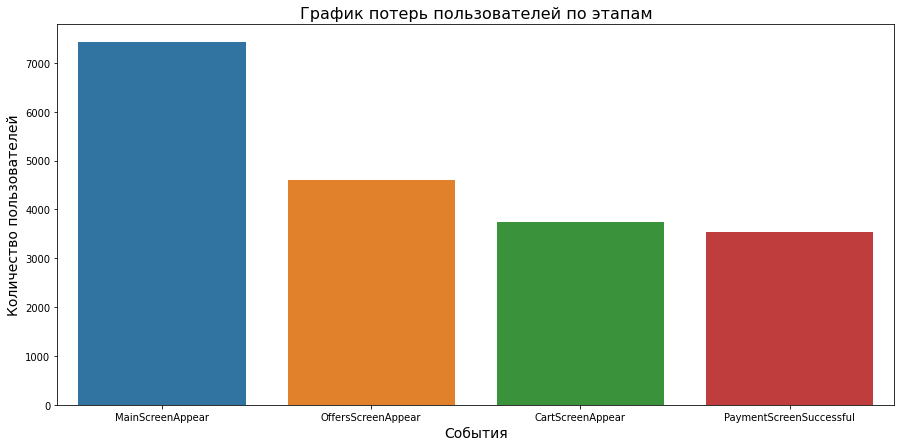

In [27]:
plt.figure(figsize =(15, 7))
sns.barplot(data=filt_user_per_event, x='event_name', y='device_id')
plt.title('График потерь пользователей по этапам', fontsize = 16)
plt.xlabel('События', fontsize = 14)
plt.ylabel('Количество пользователей', fontsize = 14);

<b>Краткий вывод: </b> Как видно из графика и раннее проведенного анализа наибольшие потери наблюдаются при переходе с главной страницы на страницы с предложениями (около 38%).

<u><b> Подсчет доли пользователей, которые доходит от первого события до оплаты

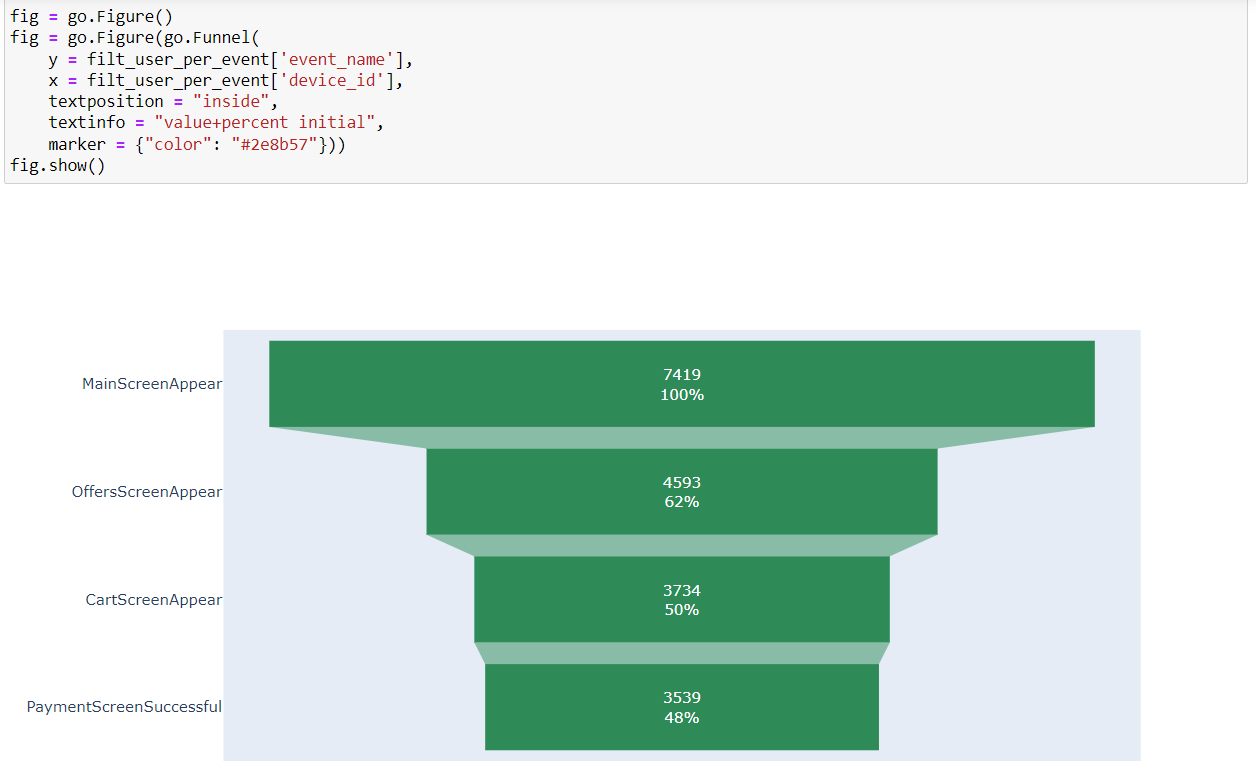

<b>Краткий вывод: </b> Из графика  и проведенного раннее анализа видно, что со стартовой страницы до страницы с оплатой доходят 48% пользователей.

<div style="text-align: justify ">
<b>Вывод: </b> В логе имеется 5 различных событий, самое популярное - просмотр главной страницы приложения (почти 99% пользователей просматривают главную страницу). Самое непопулярное событие это обучающие материалы (около 11%). С просмотра главной страницы на страницу с предложениями переходит 62% пользователей. В просмотр корзины после просмотра продукции переходит 82% пользователей. Почти 95% пользователей затем переходят на страницу с оплатой. Наибольшие потери наблюдаются при переходе с главной страницы на страницы с предложениями (около 38%), до страницы с оплатой со стартовой страницы доходит 48% пользователей.
    
<div style="text-align: justify ">
Из проведенного анализа наблюдается, что изначально пользователь заходит и просматривает главную/стартовую страницу, далее пользователь переходит на страницу с предложениями продукта. Затем просмотр корзины и переход на страницу оплаты. Стоит отметить, что процент пользователей, просмотревших корзину, и пользователей, перешедших на страницу оплаты, примерно равный - разница менее 3%.

### 5. Анализ результатов эксперимента

<u><b>Анализ числа пользователей в каждой экспериментальной группе

In [29]:
devices = logo_filt.groupby('group_id')['device_id'].nunique().reset_index()
devices

,group_id,device_id
0,246,2484
1,247,2513
2,248,2537


In [30]:
gr_240 = {'group_id': 240, 'device_id': 4997}
devices = devices.append(gr_240, ignore_index = True)
devices

,group_id,device_id
0,246,2484
1,247,2513
2,248,2537
3,240,4997


<b>Краткий вывод: </b> Во всех трех группах примерно одинаковое количество пользователей.

<u><b>Проверка статистических критериев между выборками 246 и 247

Подготовим сводная таблицу с количеством пользователей совершивших каждое из событий, дополним столбцом с объединенными группами 246 и 247. Уберем события Tutorial из анализа.

In [31]:
# уберем туториал из датафрейма
logo_filt = logo_filt.query('event_name != "Tutorial"')

#создадим сводную таблицу с числом пользователей по каждому событию
pt = logo_filt.pivot_table(index='event_name', columns='group_id',values='device_id',aggfunc='nunique').sort_values(246,ascending=False)
pt[240] = pt[246] + pt[247]
pt

group_id,246,247,248,240
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


<div style="text-align: justify ">
Для проверки статистических критериев между группами подготовим функцию Z-теста, так как выполнятся тест быдет не один раз. Также внесем поправку к уровням значимости, так как мы будем проводить мнонжественный тест. Для этого воспользуемся методом Бонферрони: уровни значимости в каждом из m сравнений в m раз меньше, чем уровень значимости, требуемый при единственном сравнении. Всего будет проведено 16 тестов. 

In [32]:
devices

,group_id,device_id
0,246,2484
1,247,2513
2,248,2537
3,240,4997


In [33]:
#функция для статистической значимости

def z_test(gr_1, gr_2, event_name, alpha):
     
        p1_logs = pt.loc[event_name, gr_1]
        p2_logs = pt.loc[event_name, gr_2]
        
        p1_devices = devices.loc[devices['group_id'] == gr_1, 'device_id'].values[0]
        p2_devices = devices.loc[devices['group_id'] == gr_2, 'device_id'].values[0]
        
        p1 = p1_logs /  p1_devices
        p2 = p2_logs /  p2_devices
        
        p_combined = (p1_logs + p2_logs) / (p1_devices + p2_devices)
        
        difference = p1 - p2 
        
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/p1_devices + 1/p2_devices))
        
        distr = stats.norm(0, 1) 
        
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        m_bonferroni = alpha/16
        
        print('Событие:', event_name)
        print('p_value:', p_value)
            
        if p_value < m_bonferroni:
            print('Отвергаем нулевую гипотезу')
        else:
            print('Не получилось отвергнуть нулевую гипотезу')
            
        print()

<i>Для упешного выполнения успешного A/A-теста необходимо, чтобы выполнялись следующие условия:</i><br> 
- Количество пользователей в различных группах различается не более, чем на 1%;<br>
- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;<br>
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;<br>
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста.<br>

In [34]:
# подсчет разинцы в количестве пользователей между группами
group_246 = logo_filt.query('group_id == 246').groupby('group_id')['device_id'].nunique().reset_index()
group_247 = logo_filt.query('group_id == 247').groupby('group_id')['device_id'].nunique().reset_index()
diff = round((1 - group_246.loc[0]['device_id'] / group_247.loc[0]['device_id'])*100, 2)
diff

1.15

Количество пользователей в группах составляет 1,15%, что удовлетворяет первому критерию, т.к. 0,15% является погрешностью.

In [35]:
# проверка на наличии пользователей в нескольких группах
len(logo_filt.groupby('device_id')['group_id'].nunique().reset_index().query('group_id > 1'))

0

В выборки нет пользователей, которые попадали бы в несколько групп, четвертый критерий успешного теста также выполняется.

Посчитаем статистическую значимость различий между группами 246 и 247.

Нулевая $H_{0}$: значимых различий между долями нет, различия статистически не значимы. 

Альтернативная $H_{1}$: значимые различия между долями есть.

In [36]:
for event_name in pt.index:
    z_test(246, 247, event_name, 0.05)

Событие: MainScreenAppear
p_value: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу

Событие: OffersScreenAppear
p_value: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу

Событие: CartScreenAppear
p_value: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу

Событие: PaymentScreenSuccessful
p_value: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу



<div style="text-align: justify ">
<b>Краткий вывод: </b> Все критерии для успешного выполнения А/А теста выполнены: во всех трех группах примерно одинаковое количество пользователей, в выборки нет пользователей, которые попадали бы в несколько групп, статистически значимых различий между группами на всех этапах не обнаружено. Таким образом, можно сделать вывод, что разбиение на группы 246 и 247 произведено корректно.

<u><b>Проверка статистических критериев между выборками 246 и 248

Посчитаем статистическую значимость различий между группами 246 и 248.

Нулевая $H_{0}$: значимых различий между долями нет, различия статистически не значимы. 

Альтернативная $H_{1}$: значимые различия между долями есть.

In [37]:
# проверка статистических критериев между группами
for event_name in pt.index:
    z_test(246, 248, event_name, 0.05)

Событие: MainScreenAppear
p_value: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу

Событие: OffersScreenAppear
p_value: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу

Событие: CartScreenAppear
p_value: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу

Событие: PaymentScreenSuccessful
p_value: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу



Как видно из проведенного эксперимента ни при одном событии не удалось отвергнуть нулевую гипотезу, статистически значимых различий между группами 246 и 248 нет. Посмотрим, имеются ли различия между 247 и 248 группами.

<u><b>Проверка статистических критериев между выборками 247 и 248

Посчитаем статистическую значимость различий между группами 247 и 248.

Нулевая $H_{0}$: значимых различий между долями нет, различия статистически не значимы. 

Альтернативная $H_{1}$: значимые различия между долями есть.

In [38]:
# проверка статистических критериев между группами
for event_name in pt.index:
    z_test(247, 248, event_name, 0.05)

Событие: MainScreenAppear
p_value: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу

Событие: OffersScreenAppear
p_value: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу

Событие: CartScreenAppear
p_value: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу

Событие: PaymentScreenSuccessful
p_value: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу



Статистически значимых различий между событиями групп 247 и 248 также нет. Посмотрим, имеются ли различия между объединенными группами 246 и 247 и  группой 248.

<u><b>Проверка статистических критериев между выборками объединенными группами 246 и 247 и группой 248

Посчитаем статистическую значимость различий между объединенными группами 246 и 247 и группой 248.

Нулевая $H_{0}$: значимых различий между долями нет, различия статистически не значимы. 

Альтернативная $H_{1}$: значимые различия между долями есть.

Ранее уже была создана группа 240, в которых были объединены группы 246 и 247.

In [39]:
# проверка статистических критериев между группами
for event_name in pt.index:
    z_test(240, 248, event_name, 0.05)

Событие: MainScreenAppear
p_value: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу

Событие: OffersScreenAppear
p_value: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу

Событие: CartScreenAppear
p_value: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу

Событие: PaymentScreenSuccessful
p_value: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу



Статистически значимых различий между событиями объединенных групп 246 и 247 и группой 248 также не наблюдаются. Таким образом можно сделать вывод, что изменения шрифтов приложения результатов не принесет.

<u><b>Уровень значимости при проверке статистических гипотез

<div style="text-align: justify ">
Для проверки статистических критериев значимости различий был выбран уровень значимости, равный 5 процентам. Было проведено 16 проверок статистических гипотез, 4 из которых в рамках проведения А/А теста. Дополнительно был применен метод Бонферрони, т.к. тест был множественным

<div style="text-align: justify ">
<b>Вывод: </b> В каждой экспериментальной группе после "очистки" данных примерно одинаковое количество пользователей. Разбиение на группы 246 и 247 произведено корректно, т.к все критерии для успешного выполнения А/А теста выполнены: во всех трех группах примерно одинаковое количество пользователей, в выборки нет пользователей, которые попадали бы в несколько групп одновременно, статистически значимых различий между группами на всех этапах не обнаружено.<br>
При проверки статистически значимых различий между группами 246 и 248, 247 и 248, а также объединенными группами 246 и 247 и группой 248 каких-либо различий не наблюдается. Для проверки статистических критериев значимости различий был выбран уровень значимости, равный 5 процентам. Так как было проведено множество тестов, дополнительно был применен метод Бонферрони. Было проведено 16 проверок статистических гипотез, 4 из которых в рамках проведения А/А теста. Таким образом можно сделать вывод, что изменения шрифтов приложения результатов не принесет.

### 6. Общий вывод по пректу

<div style="text-align: justify ">
<b><i>1) В части предобработки данных</i></b><br><br>
В ходе ознакомления и предобработки данных стало известно, что имеется массив данных <b>logs_exp</b>, который содержит данные о названии события, уникальном идентификаторе пользователя, времени события и номер группы эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная. Из столбца <b>event_time_stamp</b> были выделены дата и время, а также просто дата. Для "красоты" отображения наименования столбцов переведено в "змеиный" формат. В ходе предварительного просмотра данных пропусков не обнаружено, были обнаружены и удалены 413 явных дубликата. Каждая группа содержит почти равное количество участников.<br><br>

<div style="text-align: justify ">
<b><i>2) В части изучения и проверки данных</i></b><br><br>
Всего в логе пройдено 243 713 событий пяти различных типов. Больше всего событий "главный экран" (119 101), меньше всего "обучения" (1 018). Всего в логе 7 551 пользователя, распределенных почти равномерно по трем группам. В среднем на одного пользователя приходится 32 события. Для анализа были предоставлены данные за 2 недели на период с 25 июля по 7 августа 2019 года. В ходе дополнительной проверки было определено, что полный набор информации начинается с 1 августа. Таким образом для исследования будет взят период в одну неделю, остальные данные будут откинуты. В результате фильтрации данных из массива было удалено 17 пользователей и 2 826 события. Процент "потерянных" данных чуть более 1%, что не скажется на результатах исследования.<br><br>
    
<b><i>3) В части анализа воронки событий</i></b>
<div style="text-align: justify "> <br>   
В логе присутствует 5 различных типов событий, самое популярное - просмотр главной страницы приложения (почти 99% пользователей просматривают главную страницу). Самое непопулярное событие это обучающие материалы (около 11%). С просмотра главной страницы на страницу с предложениями переходит 62% пользователей. В просмотр корзины после просмотра продукции переходит 82% пользователей. Почти 95% пользователей затем переходят на страницу с оплатой. Наибольшие потери наблюдаются при переходе с главной страницы на страницы с предложениями (около 38%), до страницы с оплатой со стартовой страницы доходит 48% пользователей.<br>
Из проведенного анализа можно отметить, что изначально пользователь заходит и просматривает главную/стартовую страницу, далее пользователь переходит на страницу с предложениями продукта. Затем просмотр корзины и переход на страницу оплаты. Стоит отметить, что процент пользователей, просмотревших корзину, и пользователей, перешедших на страницу оплаты, примерно равный - разница менее 3%.<br><br>
   
<b><i>4) Вывод по проведенному А/В тесту</i></b>
 <div style="text-align: justify ">    <br>
В каждой экспериментальной группе после "очистки" данных примерно одинаковое количество пользователей. Разбиение на группы 246 и 247 произведено корректно, т.к все критерии для успешного выполнения А/А теста выполнены: во всех трех группах примерно одинаковое количество пользователей, в выборки нет пользователей, которые попадали бы в несколько групп одновременно, статистически значимых различий между группами на всех этапах не обнаружено.
При проверки статистически значимых различий между группами 246 и 248, 247 и 248, а также объединенными группами 246 и 247 и группой 248 каких-либо различий не наблюдается. Для проверки статистических критериев значимости различий был выбран уровень значимости, равный 5 процентам. Дополнительно был применен метод Бонферрони для множественных тестов. Было проведено 16 проверок статистических гипотез, 4 из которых в рамках проведения А/А теста. Таким образом можно сделать вывод, что изменения шрифтов приложения результатов не принесет.<br><br>

<div style="text-align: justify ">
<b><i>5) Рекомендации</i></b><br><br>
Исходя из проведенного А/В теста можно рекомендуется не принимать предложение по изменению шрифтов приложения, т.к. каких-либо видимых результатов это не принесет. Финансовые расходы и трудозатраты не окупятся.<br>
Также стоит обратить внимание на очень сильную просадку при переходе с главной страницы на страницы с предложениями. Возможно улучшение процента удержания на данном этапе принесет хороший рост дохода компании.